In [1]:
import os, sys, time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.options.mode.chained_assignment = None
import h5py

%matplotlib inline

from IPython.display import display, HTML

if (sys.version_info < (3, 0)):
    HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
# Create timestamp to show when this summary was run
print('Summary run: ' + time.strftime("%a, %d %b %Y %H:%M:%S"))

Summary run: Tue, 02 Jul 2024 13:00:11


In [3]:
pd.options.display.float_format = '{:0,.0f}'.format

In [4]:
# Region
# Counties
# RGC
# MIC
# HCT Areas
# Regional Geographies
# Equity Geographies (over 50%)
# Equity Geographies (over Regional Average)


# Travel Metrics
# Transit Ridership
# Congestion Levels
# Truck Data
# VMT
# Delay
# Miles of Congestion
# Vehicle Data
# VMT
# Delay
# Miles of Congestion

In [5]:
geog = 'rg'
geog_col = 'hh_rg_proposed'

# Regional Geography
Results based on household location


# Population

In [6]:
df = pd.read_csv(r'..\..\..\outputs\agg\dash\person_geog.csv')
_df_pop = df.groupby(geog_col).sum()[['psexpfac']]

df = pd.read_csv(r'..\..\..\outputs\agg\dash\hh_geog.csv')
_df_hh = df.groupby(geog_col).sum()[['hhexpfac']]

df = _df_hh.merge(_df_pop, on=geog_col)
df.rename(columns={'hhexpfac': 'Households', 'psexpfac': 'Persons'}, inplace=True)
df.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare',geog,'1_population.csv'))
df.loc['Total'] = df.sum(axis=0)
df

,Households,Persons
hh_rg_proposed,,
CitiesTowns,"134,133","380,485"
Core,"386,598","1,001,203"
HCT,"360,163","957,710"
Metro,"590,450","1,280,445"
Rural,"199,420","545,663"
UU,"65,365","190,526"
Total,"1,736,129","4,356,032"


# Employment

In [7]:
df = pd.read_csv(r'..\..\..\outputs\agg\dash\person_geog.csv')
df = df[df['pwtyp'].isin(['Paid Full-Time Worker', 'Paid Part-Time Worker'])]
_df = df.pivot_table(index=geog_col, columns='pwtyp', aggfunc='sum', values='psexpfac')
_df.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare',geog,'2_employment.csv'))
_df.loc['Total'] = _df.sum(axis=0)
_df['Total'] = _df.sum(axis=1)
_df

pwtyp,Paid Full-Time Worker,Paid Part-Time Worker,Total
hh_rg_proposed,,,
CitiesTowns,"151,933","38,603","190,536"
Core,"414,039","102,807","516,846"
HCT,"389,990","96,618","486,608"
Metro,"601,211","137,541","738,752"
Rural,"203,534","55,284","258,818"
UU,"72,501","17,071","89,572"
Total,"1,833,208","447,924","2,281,132"



### Transit Ridership

#### Total trips

In [8]:
# Region
# By Agency

# Transit Trips from Daysim, by location
df = pd.read_csv(r'..\..\..\outputs\agg\dash\mode_share_'+geog+'.csv')
_df = df[df['mode']=='Transit'].groupby(geog_col).sum()[['trexpfac']]
_df.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare',geog,'3_transit_trips.csv'))
_df.loc['Total'] = _df.sum(axis=0)
_df

,trexpfac
hh_rg_proposed,
CitiesTowns,"11,621"
Core,"82,843"
HCT,"64,036"
Metro,"231,724"
Rural,"12,671"
UU,"4,832"
Total,"407,727"


#### % Commute Trips by Transit (Home to Work direct)

In [9]:
# Mode share
df = df[df['dpurp'] == 'Work']
_df = df.pivot_table(index=[geog_col, 'mode'], aggfunc='sum', values='trexpfac').reset_index()
_df_tot = _df.groupby(geog_col).sum()[['trexpfac']]
_df = _df.merge(_df_tot, how='left', on=geog_col)
_df['mode_share'] = _df['trexpfac_x']/_df['trexpfac_y']

_df = _df[_df['mode'] == 'Transit'][[geog_col,'mode_share']]
pd.options.display.float_format = '{:0,.1%}'.format
_df.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare',geog,'4_transit_commute_share.csv'))
_df

,hh_rg_proposed,mode_share
6,CitiesTowns,2.6%
14,Core,4.9%
22,HCT,4.6%
30,Metro,7.1%
38,Rural,2.5%
46,UU,2.5%


## VMT

,VMT,% of VMT
hh_rg_proposed,,
CitiesTowns,"6,971,798",10.9%
Core,"14,105,262",22.0%
HCT,"14,583,365",22.7%
Metro,"13,048,048",20.4%
Rural,"12,230,857",19.1%
UU,"3,166,171",4.9%
Total,"64,105,502",100.0%


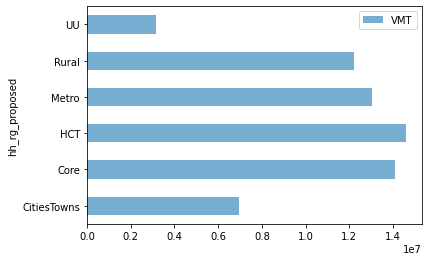

In [10]:
pd.options.display.float_format = '{:0,.0f}'.format
# aggfunc sum trips filtered by dorp==1 and auto modes | groupby hh_rg_proposed
# hh_rg_proposed, 
df = pd.read_csv(r'..\..\..\outputs\agg\dash\person_vmt.csv')
df = df[(df['dorp'] == 1) & (df['mode'].isin(['SOV','HOV2','HOV3+']))]
_df = df.groupby(geog_col).sum()[['travdist_wt']]
_df['% of VMT'] = (_df/_df.sum()).astype('float')
_df.rename(columns={'travdist_wt': 'VMT'}, inplace=True)
_df.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare',geog,'5_vmt.csv'))
_df[['VMT']].plot(kind='barh', alpha=0.6)
_df.loc['Total'] = _df.sum(axis=0)
_df['% of VMT'] = _df['% of VMT'].apply('{:0,.1%}'.format)
_df

,VHT,% of VHT
hh_rg_proposed,,
CitiesTowns,"244,445",9.6%
Core,"564,952",22.1%
HCT,"577,292",22.6%
Metro,"624,696",24.4%
Rural,"428,747",16.8%
UU,"118,355",4.6%
Total,"2,558,487",100.0%


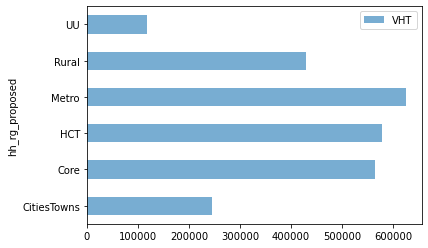

In [11]:
pd.options.display.float_format = '{:0,.0f}'.format
# aggfunc sum trips filtered by dorp==1 and auto modes | groupby hh_rg_proposed
# hh_rg_proposed, 
df = pd.read_csv(r'..\..\..\outputs\agg\dash\person_vht.csv')
df = df[(df['dorp'] == 1) & (df['mode'].isin(['SOV','HOV2','HOV3+']))]
_df = df.groupby(geog_col).sum()[['travtime_wt']]/60.0
_df['% of VHT'] = (_df/_df.sum()).astype('float')
_df.rename(columns={'travtime_wt': 'VHT'}, inplace=True)
_df[['VHT']].plot(kind='barh', alpha=0.6)
_df.loc['Total'] = _df.sum(axis=0)
_df['% of VHT'] = _df['% of VHT'].apply('{:0,.1%}'.format)
_df.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare',geog,'6_vht.csv'))
_df

## Delay
Calculated based on Household Location

In [12]:
# might need to be calculated individually?
# create a delay summary from total vmt and total sov_ff_time

In [13]:
df = pd.read_csv(r'..\..\..\outputs\agg\dash\trip_time_total.csv')
df = df.groupby(geog_col).sum()[['travtime_wt']]

df2 = pd.read_csv(r'..\..\..\outputs\agg\dash\trip_sov_ff_time.csv')
df2 = df2.groupby(geog_col).sum()[['sov_ff_time_wt']]
df = df2.merge(df, on=geog_col)

# Hours of delay from travel time (in min)
df['Total Delay Hours'] = (df['travtime_wt'] - df['sov_ff_time_wt'])/60

pd.options.display.float_format = '{:0,.0f}'.format
# Hours of delay for households in these locations
df[['Total Delay Hours']]

_df

,VHT,% of VHT
hh_rg_proposed,,
CitiesTowns,"244,445",9.6%
Core,"564,952",22.1%
HCT,"577,292",22.6%
Metro,"624,696",24.4%
Rural,"428,747",16.8%
UU,"118,355",4.6%
Total,"2,558,487",100.0%


#### Average Delay Minutes per Household (per Weekday)

In [14]:
# Average minutes of delay per household
pd.options.display.float_format = '{:0,.1f}'.format
_df = _df_hh.merge(df[['Total Delay Hours']], left_index=True, right_index=True)
df['Avg. Minutes of Delay per Household'] = df['Total Delay Hours']/_df['hhexpfac']*60
df.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare',geog,'7_delay.csv'))

df[['Avg. Minutes of Delay per Household']]

,Avg. Minutes of Delay per Household
hh_rg_proposed,
CitiesTowns,10.9
Core,9.4
HCT,11.5
Metro,5.6
Rural,9.5
UU,11.3
